# PROJET : DATA MINING 

DOSSIER     -> nom du dossier où seront stockées les images  
query       -> requête SPARQL pour récupérer les images  

SPARQL :  
> stars -> Q523  
> exoplanet -> Q44559  
> space probe -> Q26529  
> landscapes -> Q107425  
> spaceship -> Q40218  
> spaceflight -> Q5916

Folder :  
> stars -> data_stars  
> exoplanet -> data_exoplanet  
> space probe -> data_spaceprobe  
> landscapes -> data_landscapes  
> spaceship -> data_spaceship  
> spaceflight -> data_spaceship


## importation

In [1]:
import sys
from SPARQLWrapper import SPARQLWrapper, JSON
import requests
import shutil
import os
import json
import matplotlib.pyplot as plt
import pandas as pd
import tkinter as tk
from PIL import Image, ImageTk
from PIL.ExifTags import TAGS
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
import random
from PIL import Image as PILImage
from interface import Application

## Code pour les interface

In [2]:
class ImageImportationApp:
    def __init__(self, root: tk.Tk):
        self.importation = None
        self.root = root
        self.setup_ui()

    def setup_ui(self):
        self.root.title("Importation d'image")

        # Définir la taille de la fenêtre
        largeur_fenetre = 300
        hauteur_fenetre = 80

        # Centrer la fenêtre
        self.centrer_fenetre(self.root, largeur_fenetre, hauteur_fenetre)

        # Amener la fenêtre au premier plan
        self.root.lift()
        self.root.attributes("-topmost", True)
        self.root.after_idle(self.root.attributes, "-topmost", False)

        # Créer une étiquette
        label = tk.Label(self.root, text="Faire l'importation d'image ?")
        label.pack(pady=10)

        # Créer un conteneur Frame pour les boutons
        button_frame = tk.Frame(self.root)
        button_frame.pack()

        # Créer un bouton "Oui"
        yes_button = tk.Button(button_frame, text="Oui", command=self.on_yes)
        yes_button.pack(side=tk.LEFT, padx=10)

        # Créer un bouton "Non"
        no_button = tk.Button(button_frame, text="Non", command=self.on_no)
        no_button.pack(side=tk.RIGHT, padx=10)

    def on_yes(self):
        self.importation = "oui"
        self.root.destroy()

    def on_no(self):
        self.importation = "non"
        self.root.destroy()

    def centrer_fenetre(self, fenetre: tk.Tk, largeur: int, hauteur: int):
        # Obtenir la largeur et la hauteur de l'écran
        largeur_ecran = fenetre.winfo_screenwidth()
        hauteur_ecran = fenetre.winfo_screenheight()

        # Calculer la position x et y pour centrer la fenêtre
        x = (largeur_ecran - largeur) // 2
        y = (hauteur_ecran - hauteur) // 2

        # Définir la géométrie de la fenêtre
        fenetre.geometry(f"{largeur}x{hauteur}+{x}+{y}")


class DataImporter:
    def __init__(self, root: tk.Tk, data: dict[str, dict[str, str]]):
        self.data = data
        self.info_a_traiter = None
        self.root = root
        self.create_window()

    def traiter_reponse(self):
        self.info_a_traiter = self.var.get()
        self.root.destroy()

    def centrer_fenetre(self, fenetre: tk.Tk, largeur: int, hauteur: int):
        largeur_ecran = fenetre.winfo_screenwidth()
        hauteur_ecran = fenetre.winfo_screenheight()
        x = (largeur_ecran - largeur) // 2
        y = (hauteur_ecran - hauteur) // 2
        fenetre.geometry(f"{largeur}x{hauteur}+{x}+{y}")

    def create_window(self):
        self.root.title("Choix d'information")
        largeur_fenetre = 300
        hauteur_fenetre = 30 * (len(self.data) + 2) + 20
        self.centrer_fenetre(self.root, largeur_fenetre, hauteur_fenetre)
        self.root.lift()
        self.root.attributes("-topmost", True)
        self.root.after_idle(self.root.attributes, "-topmost", False)
        self.var = tk.StringVar(value="rien")
        frame = tk.Frame(self.root)
        frame.pack(expand=True, fill="both")
        for key in self.data.keys():
            tk.Radiobutton(frame, text=key.title(), variable=self.var, value=key).pack(
                anchor=tk.CENTER, pady=1
            )
        tk.Radiobutton(frame, text="Tout", variable=self.var, value="tout").pack(
            anchor=tk.CENTER, pady=1
        )
        tk.Radiobutton(frame, text="Rien", variable=self.var, value="rien").pack(
            anchor=tk.CENTER, pady=1
        )
        tk.Button(self.root, text="Soumettre", command=self.traiter_reponse).pack(
            anchor=tk.CENTER, pady=3
        )


class ImageSelectionApp:
    def __init__(self, root, df, nb_images=10):

        self.root = root
        self.df = df
        self.selected_images = []

        self.root.title("Sélectionner des images favorites")

        nb_images_sur_2 = nb_images // 2
        nb_ligne = -(-nb_images // nb_images_sur_2)  # Arrondi à l'unité supérieure

        # image taille
        image_largeur = 200
        image_hauteur = 200

        # Définir la taille de la fenêtre
        largeur_fenetre = (image_largeur + 20) * nb_images_sur_2 + 10
        hauteur_fenetre = (image_hauteur + 20) * nb_ligne + 50

        # Centrer la fenêtre
        self.centrer_fenetre(root, largeur_fenetre, hauteur_fenetre)

        # Amener la fenêtre au premier plan
        root.lift()
        root.attributes("-topmost", True)
        root.after_idle(root.attributes, "-topmost", False)

        # Créer une frame pour les images
        self.image_frame = tk.Frame(self.root)
        self.image_frame.pack()

        self.checkboxes_var = []
        self.image_widgets = []
        self.selected = []
        self.id_used = []

        # Afficher les images et les cases à cocher
        for i in range(min(nb_images, len(self.df))):
            while True:
                ramdom_index = np.random.randint(0, len(self.df))
                if ramdom_index not in self.id_used:
                    self.id_used.append(ramdom_index)
                    break
            img_path = self.df["image"][ramdom_index]
            image = PILImage.open(img_path)
            image.thumbnail((image_largeur, image_hauteur))  # Redimensionner l'image
            image_tk = ImageTk.PhotoImage(image)
            image_widget = tk.Label(self.image_frame, image=image_tk)
            image_widget.image = image_tk  # Garder une référence à l'image
            # Disposer les images sur deux lignes avec trois images par ligne
            row = i // nb_images_sur_2  # Pour avoir 3 images par ligne
            col = i % nb_images_sur_2  # Colonnes 0, 1, 2
            image_widget.grid(row=row * 2, column=col)

            self.image_widgets.append(image_widget)

            var = tk.IntVar(value=0)
            checkbox = tk.Checkbutton(self.image_frame, text="Favorite", variable=var)
            checkbox.grid(
                row=row * 2 + 1, column=col
            )  # Positionner le checkbox sous l'image

            self.checkboxes_var.append(var)

        # Ajouter un bouton pour récupérer les images sélectionnées
        self.select_button = tk.Button(
            self.root, text="Sélectionner", command=self.show_selected_images
        )
        self.select_button.pack()

    def centrer_fenetre(self, fenetre: tk.Tk, largeur: int, hauteur: int):
        # Obtenir la largeur et la hauteur de l'écran
        largeur_ecran = fenetre.winfo_screenwidth()
        hauteur_ecran = fenetre.winfo_screenheight()

        # Calculer la position x et y pour centrer la fenêtre
        x = (largeur_ecran - largeur) // 2
        y = (hauteur_ecran - hauteur) // 2

        # Définir la géométrie de la fenêtre
        fenetre.geometry(f"{largeur}x{hauteur}+{x}+{y}")

    def show_selected_images(self):
        # Récupérer les images sélectionnées
        for i, checkbox in enumerate(self.checkboxes_var):
            img_path = self.df["image"][self.id_used[i]]
            if checkbox.get() == 1:  # Si la case est cochée
                self.selected.append(("Favorite", img_path))
            else:
                self.selected.append(("NotFavorite", img_path))

        self.root.destroy()


class RecommendedImagesApp:
    def __init__(self, root, recommendations, df_all_exif_clean):
        self.root = root
        self.recommendations = recommendations
        self.df_all_exif_clean = df_all_exif_clean
        self.image_labels = []
        self.setup_ui()

    def centrer_fenetre(self, fenetre: tk.Tk, largeur: int, hauteur: int):
        # Obtenir la largeur et la hauteur de l'écran
        largeur_ecran = fenetre.winfo_screenwidth()
        hauteur_ecran = fenetre.winfo_screenheight()

        # Calculer la position x et y pour centrer la fenêtre
        x = (largeur_ecran - largeur) // 2
        y = (hauteur_ecran - hauteur) // 2

        # Définir la géométrie de la fenêtre
        fenetre.geometry(f"{largeur}x{hauteur}+{x}+{y}")

    def setup_ui(self):
        self.root.title("Recommended Images")

        self.centrer_fenetre(self.root, 230 * 3, 280)

        # Add the title text above the images
        text_label = tk.Label(
            self.root,
            text="Voici trois images qui vont surement vous plaire",
            font=("Arial", 14),
        )
        text_label.grid(
            row=0, column=0, columnspan=3, pady=10
        )  # Span across all columns

        # Get the image paths from the recommendations
        indices_lignes = self.recommendations.index.tolist()
        image_paths = [
            self.df_all_exif_clean.iloc[indices_lignes[0]]["image"],
            self.df_all_exif_clean.iloc[indices_lignes[1]]["image"],
            self.df_all_exif_clean.iloc[indices_lignes[2]]["image"],
        ]

        # Display the images in the tkinter window
        for i, path in enumerate(image_paths):
            img = Image.open(path)
            img.thumbnail((200, 200))  # Resize the image to fit in the window
            img_tk = ImageTk.PhotoImage(img)

            label = tk.Label(self.root, image=img_tk)
            label.image = img_tk  # Keep a reference to the image
            label.grid(row=1, column=i, padx=10, pady=10)

            # Store the image reference in a list to prevent garbage collection
            self.image_labels.append(label)


class RandomImageApp:
    def __init__(self, root, image_path, prediction):
        self.root = root
        self.image_path = image_path
        self.prediction = prediction
        self.setup_ui()

    def centrer_fenetre(self, fenetre: tk.Tk, largeur: int, hauteur: int):
        largeur_ecran = fenetre.winfo_screenwidth()
        hauteur_ecran = fenetre.winfo_screenheight()
        x = (largeur_ecran - largeur) // 2
        y = (hauteur_ecran - hauteur) // 2
        fenetre.geometry(f"{largeur}x{hauteur}+{x}+{y}")

    def setup_ui(self):
        self.root.title("Random Image Prediction")

        img = Image.open(self.image_path)
        img.thumbnail((400, 400))  # Redimensionner l'image pour s'adapter à la fenêtre
        img_tk = ImageTk.PhotoImage(img)

        label = tk.Label(self.root, image=img_tk)
        label.image = img_tk  # Garder une référence à l'image
        label.pack()

        prediction_text = f"Prediction: {'Favorite' if self.prediction == 'Favorite' else 'Non favorite'}"
        prediction_label = tk.Label(
            self.root, text=prediction_text, font=("Helvetica", 16)
        )
        prediction_label.pack(pady=10)

        self.centrer_fenetre(self.root, img.width + 20, img.height + 70)


class QuestionfullApp:
    def __init__(self, root: tk.Tk):
        self.importation = None
        self.root = root
        self.setup_ui()

    def setup_ui(self):
        self.root.title("Question")

        # Définir la taille de la fenêtre
        largeur_fenetre = 300
        hauteur_fenetre = 80

        # Centrer la fenêtre
        self.centrer_fenetre(self.root, largeur_fenetre, hauteur_fenetre)

        # Amener la fenêtre au premier plan
        self.root.lift()
        self.root.attributes("-topmost", True)
        self.root.after_idle(self.root.attributes, "-topmost", False)

        # Créer une étiquette
        label = tk.Label(self.root, text="Utiliser l'application ?")
        label.pack(pady=10)

        # Créer un conteneur Frame pour les boutons
        button_frame = tk.Frame(self.root)
        button_frame.pack()

        # Créer un bouton "Oui"
        yes_button = tk.Button(button_frame, text="Oui", command=self.on_yes)
        yes_button.pack(side=tk.LEFT, padx=10)

        # Créer un bouton "Non"
        no_button = tk.Button(button_frame, text="Non", command=self.on_no)
        no_button.pack(side=tk.RIGHT, padx=10)

    def on_yes(self):
        self.importation = "oui"
        self.root.destroy()

    def on_no(self):
        self.importation = "non"
        self.root.destroy()

    def centrer_fenetre(self, fenetre: tk.Tk, largeur: int, hauteur: int):
        # Obtenir la largeur et la hauteur de l'écran
        largeur_ecran = fenetre.winfo_screenwidth()
        hauteur_ecran = fenetre.winfo_screenheight()

        # Calculer la position x et y pour centrer la fenêtre
        x = (largeur_ecran - largeur) // 2
        y = (hauteur_ecran - hauteur) // 2

        # Définir la géométrie de la fenêtre
        fenetre.geometry(f"{largeur}x{hauteur}+{x}+{y}")

## Choix full interface ou continuer sur Jupyter notebook

In [3]:
root = tk.Tk()
app = QuestionfullApp(root)
root.mainloop()
importation = app.importation
if importation == "oui":
    app = Application()
    app.mainloop()

## Collecte de données

In [4]:
# Charger les données depuis un fichier JSON
DATA: dict[str, dict[str, str]] = json.load(open("data.json", encoding="utf-8"))

# Limite du nombre de résultats à récupérer
LIMIT = 150

In [5]:
# Créer une nouvelle fenêtre tkinter
root = tk.Tk()

# Initialiser l'application d'importation d'image
app = ImageImportationApp(root)

# Lancer la boucle principale de l'interface graphique
root.mainloop()

# Récupérer la réponse de l'utilisateur
importation = app.importation

# Afficher la réponse de l'utilisateur
print(f"Réponse de l'utilisateur : {importation}")

Réponse de l'utilisateur : non


In [6]:
import os
import shutil
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
import pandas as pd
from SPARQLWrapper import SPARQLWrapper, JSON
import sys
import tkinter as tk

# Importation des bibliothèques nécessaires


# Initialisation de l'interface Tkinter

root = tk.Tk()

data_importer = DataImporter(root, DATA)

root.mainloop()

info_a_traiter = data_importer.info_a_traiter


# Création du dossier "images" s'il n'existe pas

if not os.path.exists("images"):

    os.mkdir("images")



# Fonction pour importer les données

def import_data(dossier, query, prefix):

    # Création du dossier s'il n'existe pas

    if not os.path.exists(dossier):

        os.mkdir(dossier)


    # Fonction pour sauvegarder les données dans un fichier CSV

    def save_data(dataframe):

        dataframe.to_csv(dossier + "/data.csv", index=False)


    # Fonction pour télécharger une image

    def download_image(url, id, prefix):

        headers = {"User-Agent": "Mozilla/5.0"}


        # Configuration des nouvelles tentatives

        retry_strategy = Retry(

            total=5,  # Nombre total de tentatives

            status_forcelist=[
                500,
                502,
                503,
                504,
            ],  # Codes de statut pour lesquels une nouvelle tentative sera effectuée

            allowed_methods=[
                "HEAD",
                "GET",
                "OPTIONS",
            ],  # Méthodes pour lesquelles une nouvelle tentative sera effectuée

            backoff_factor=1,  # Facteur de réduction exponentielle

        )


        adapter = HTTPAdapter(max_retries=retry_strategy)

        session = requests.Session()

        session.mount("https://", adapter)

        session.mount("http://", adapter)


        # Envoi de la requête pour télécharger l'image

        request = session.get(
            url, allow_redirects=True, headers=headers, stream=True, timeout=60
        )

        if request.status_code == 200:

            with open(
                dossier + "/" + prefix + str(id) + os.path.splitext(url)[1], "wb"
            ) as image:

                request.raw.decode_content = True

                shutil.copyfileobj(request.raw, image)

            return dossier + "/" + prefix + str(id) + os.path.splitext(url)[1]

        return "None"


    # Fonction pour obtenir les résultats de la requête SPARQL

    def get_results(endpoint_url, query):

        user_agent = "WDQS-example Python/%s.%s" % (
            sys.version_info[0],
            sys.version_info[1],
        )

        sparql = SPARQLWrapper(endpoint_url, agent=user_agent)

        sparql.setQuery(query)

        sparql.setReturnFormat(JSON)

        return sparql.query().convert()


    endpoint_url = "https://query.wikidata.org/sparql"


    array = []

    results = get_results(endpoint_url, query)


    # Parcours des résultats et ajout des données dans un tableau

    for result in results["results"]["bindings"]:

        array.append(
            (results["results"]["bindings"].index(result) + 1, result["image"]["value"])
        )


    # Création d'un DataFrame à partir du tableau

    dataframe = pd.DataFrame(array, columns=["id", "image"])

    dataframe = dataframe.astype(dtype={"id": "int", "image": "<U200"})


    # Téléchargement des images et mise à jour du DataFrame

    dataframe["image"] = dataframe.apply(
        lambda row: download_image(row["image"], row["id"], prefix), axis=1
    )


    # Sauvegarde des données dans un fichier CSV

    save_data(dataframe)
    return dataframe



# Dictionnaire pour stocker les DataFrames

dataframes = {}

if info_a_traiter == "tout":

    for key, value in DATA.items():

        query = f"""

        SELECT ?item ?itemLabel ?image

        WHERE

        {{

          ?item wdt:P31 wd:{value["sparql"]}.

          ?item wdt:P18 ?image.

          SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }}

        }}

        limit {LIMIT}
        """

        if importation == "oui":

            dataframes[value["folder"]] = import_data(
                "images/" + value["folder"], query, value["prefix"]
            )

        elif importation == "non":

            dataframes[value["folder"]] = pd.read_csv(
                "images/" + value["folder"] + "/data.csv"
            )

elif info_a_traiter and info_a_traiter in DATA.keys():

    query = f"""

    SELECT ?item ?itemLabel ?image

    WHERE

    {{

      ?item wdt:P31 wd:{DATA[info_a_traiter]["sparql"]}.

      ?item wdt:P18 ?image.

      SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }}

    }}

    limit {LIMIT}
    """

    if importation == "oui":

        dataframes[DATA[info_a_traiter]["folder"]] = import_data(

            "images/" + DATA[info_a_traiter]["folder"],
            query,
            DATA[info_a_traiter]["prefix"],

        )

    elif importation == "non":

        dataframes[DATA[info_a_traiter]["folder"]] = pd.read_csv(
            "images/" + DATA[info_a_traiter]["folder"] + "/data.csv"
        )


# Affichage des DataFrames

for key, dataframe in dataframes.items():

    print(key)

    print(dataframe)

    print("\n")

dataframes

data_exoplanet
      id                            image
0      1    images/data_exoplanet/ep1.png
1      2    images/data_exoplanet/ep2.png
2      3    images/data_exoplanet/ep3.png
3      4    images/data_exoplanet/ep4.jpg
4      5    images/data_exoplanet/ep5.jpg
..   ...                              ...
145  146  images/data_exoplanet/ep146.jpg
146  147  images/data_exoplanet/ep147.jpg
147  148  images/data_exoplanet/ep148.png
148  149  images/data_exoplanet/ep149.jpg
149  150  images/data_exoplanet/ep150.jpg

[150 rows x 2 columns]


data_stars
      id                        image
0      1    images/data_stars/st1.jpg
1      2    images/data_stars/st2.svg
2      3    images/data_stars/st3.jpg
3      4    images/data_stars/st4.jpg
4      5    images/data_stars/st5.jpg
..   ...                          ...
145  146  images/data_stars/st146.jpg
146  147  images/data_stars/st147.jpg
147  148  images/data_stars/st148.svg
148  149  images/data_stars/st149.jpg
149  150  images/data_star

{'data_exoplanet':       id                            image
 0      1    images/data_exoplanet/ep1.png
 1      2    images/data_exoplanet/ep2.png
 2      3    images/data_exoplanet/ep3.png
 3      4    images/data_exoplanet/ep4.jpg
 4      5    images/data_exoplanet/ep5.jpg
 ..   ...                              ...
 145  146  images/data_exoplanet/ep146.jpg
 146  147  images/data_exoplanet/ep147.jpg
 147  148  images/data_exoplanet/ep148.png
 148  149  images/data_exoplanet/ep149.jpg
 149  150  images/data_exoplanet/ep150.jpg
 
 [150 rows x 2 columns],
 'data_stars':       id                        image
 0      1    images/data_stars/st1.jpg
 1      2    images/data_stars/st2.svg
 2      3    images/data_stars/st3.jpg
 3      4    images/data_stars/st4.jpg
 4      5    images/data_stars/st5.jpg
 ..   ...                          ...
 145  146  images/data_stars/st146.jpg
 146  147  images/data_stars/st147.jpg
 147  148  images/data_stars/st148.svg
 148  149  images/data_stars/st149.

## Cree dataframe avec photo ayant des EXIF

In [7]:
def extract_exif_date(df):
    # Fonction pour extraire la date EXIF d'une image
    def get_exif_date(img_path):
        try:
            img = PILImage.open(img_path)
            exif_data = img.getexif()
            if exif_data is not None:
                for tag, value in exif_data.items():
                    if TAGS.get(tag, tag) == "DateTime":
                        return value
        except:
            return None

    # Appliquer la fonction get_exif_date à chaque image du DataFrame
    df["date_prise_vue"] = df["image"].apply(get_exif_date)
    return df.dropna(subset=["date_prise_vue"])


# Appliquer le filtre EXIF sur les différents datasets
df_exif = {}
for key, df_image_data_user in dataframes.items():
    df_exif[key] = extract_exif_date(df_image_data_user)

# Affichage des tailles après filtrage
print("Nombre de lignes après filtre EXIF :")
for key, df_image_data_user in df_exif.items():
    print(f"{key} : {df_image_data_user.shape[0]}")

# Fusionner les DataFrames filtrés en un seul
df_all_exif = pd.concat([df for df in df_exif.values()], ignore_index=True)

# Affichage de la taille finale
print("Nombre total de lignes après filtre EXIF :", df_all_exif.shape[0])
# print(df_all_exif)

Nombre de lignes après filtre EXIF :
data_exoplanet : 25
data_stars : 29
data_spaceprobe : 34
data_spaceship : 15
Nombre total de lignes après filtre EXIF : 103


## Étiquetage et annotation

In [8]:
# Dictionnaire des couleurs avec leurs valeurs RGB
colors_dict = {
    "Rouge": [255, 0, 0],
    "Vert": [0, 255, 0],
    "Bleu": [0, 0, 255],
    "Jaune": [255, 255, 0],
    "Cyan": [0, 255, 255],
    "Magenta": [255, 0, 255],
    "Blanc": [255, 255, 255],
    "Noir": [0, 0, 0],
}


# Fonction pour extraire les métadonnées d'une image
def get_image_metadata(image_path):
    try:
        img = Image.open(image_path).convert("RGB")
        img_array = np.array(img)

        # Taille et dimensions
        width, height = img.size
        file_size = width * height  # Nombre total de pixels

        # Orientation
        orientation = (
            "Paysage" if width > height else "Portrait" if height > width else "Carré"
        )

        # Comparer la couleur moyenne à chaque couleur du dictionnaire
        avg_color = img_array.mean(axis=(0, 1))  # Moyenne des couleurs R, G, B
        closest_color = min(
            colors_dict,
            key=lambda color: np.sqrt(
                np.sum((np.array(avg_color) - np.array(colors_dict[color])) ** 2)
            ),
        )

        # Luminosité
        luminosity = (
            0.2126 * img_array[:, :, 0].mean()
            + 0.7152 * img_array[:, :, 1].mean()
            + 0.0722 * img_array[:, :, 2].mean()
        )

        return [file_size, orientation, closest_color, round(luminosity, 1)]

    except Exception as e:
        print(f"Erreur avec {image_path} : {e}")
        return [None, None, None, None]


# Extraire les métadonnées pour chaque image en utilisant le DataFrame
df_all_exif[["taille_pixels", "orientation", "dominant_color_rgb", "luminosity"]] = (
    df_all_exif["image"].apply(lambda x: pd.Series(get_image_metadata(x)))
)

# Supprimer les lignes où il y a des valeurs None ou NaN
df_image_data_user = df_all_exif.dropna(
    subset=["taille_pixels", "orientation", "dominant_color_rgb", "luminosity"]
)

print(f"Nombre total de lignes après filtre : {df_image_data_user.shape[0]}")

# Changer la date en année uniquement
df_image_data_user["date_prise_vue"] = df_image_data_user["date_prise_vue"].astype(str)
df_image_data_user["date_prise_vue"] = df_image_data_user["date_prise_vue"].str[:4]

# Extraction du dossier après "images/"
df_image_data_user["tag"] = df_image_data_user["image"].str.split("/").str[1]

# Affichage du DataFrame mis à jour
print("\nAffichage de la première ligne du DataFrame:")
print(df_image_data_user.iloc[1])
print("Colonnes de df_image_data_user :", df_image_data_user.columns.tolist())

Nombre total de lignes après filtre : 103

Affichage de la première ligne du DataFrame:
id                                                27
image                 images/data_exoplanet/ep27.jpg
date_prise_vue                                  2010
taille_pixels                               16000000
orientation                                    Carré
dominant_color_rgb                              Noir
luminosity                                      33.7
tag                                   data_exoplanet
Name: 1, dtype: object
Colonnes de df_image_data_user : ['id', 'image', 'date_prise_vue', 'taille_pixels', 'orientation', 'dominant_color_rgb', 'luminosity', 'tag']


## Visualisation des données

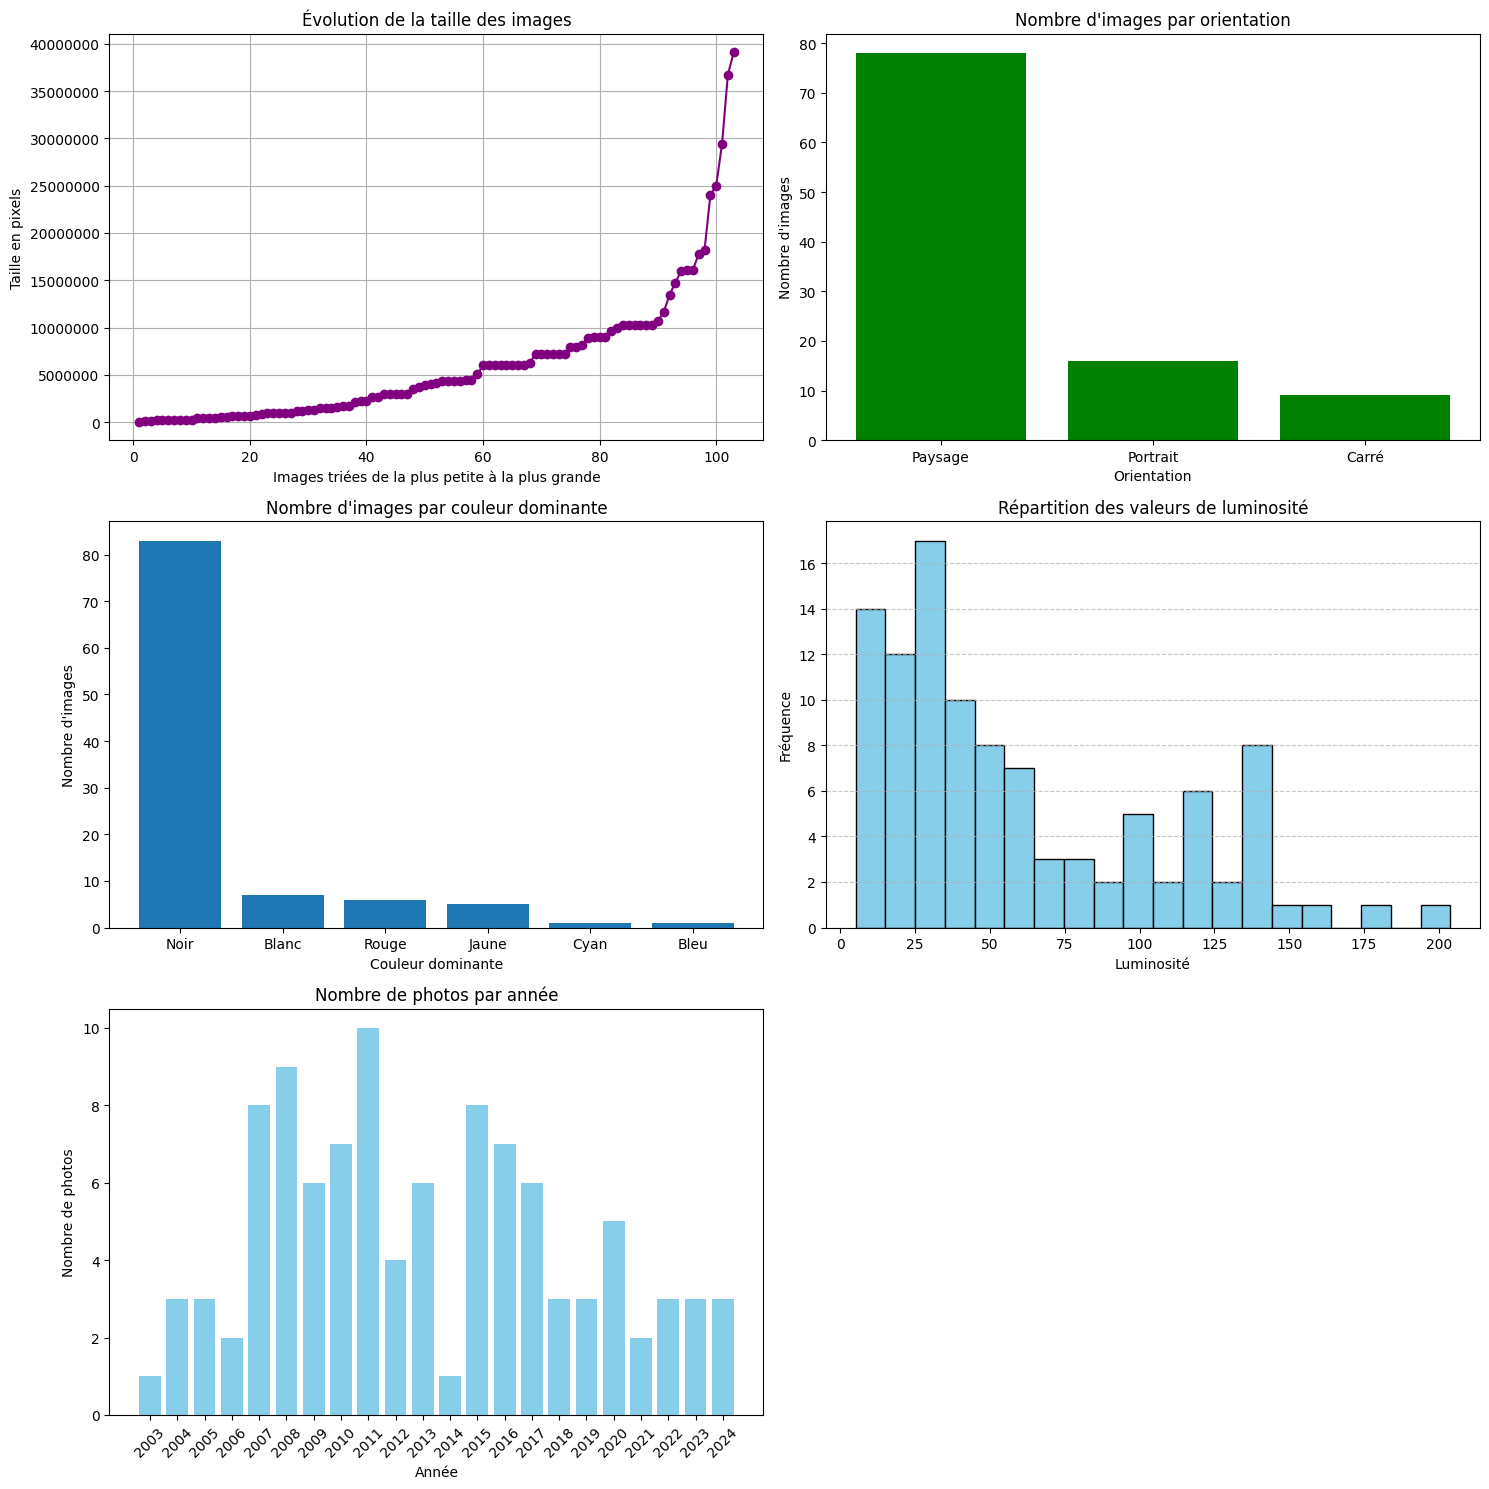

In [9]:
# Créer une figure avec 3 lignes et 2 colonnes de subplots (le dernier sera supprimé)
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
axs = axs.flatten()

# Sous-graphique 1 : Courbe de la taille des pixels en ordre croissant
df_sorted = df_image_data_user.sort_values(by="taille_pixels")
axs[0].plot(
    range(1, len(df_sorted) + 1),
    df_sorted["taille_pixels"],
    marker="o",
    linestyle="-",
    color="purple",
)
axs[0].set_xlabel("Images triées de la plus petite à la plus grande")
axs[0].set_ylabel("Taille en pixels")
axs[0].set_title("Évolution de la taille des images")
axs[0].grid(True)
axs[0].ticklabel_format(style="plain", axis="y")

# Sous-graphique 2 : Nombre d'images par orientation
df_orientation = df_image_data_user["orientation"].value_counts()
axs[1].bar(df_orientation.index, df_orientation, color="green")
axs[1].set_xlabel("Orientation")
axs[1].set_ylabel("Nombre d'images")
axs[1].set_title("Nombre d'images par orientation")

# Sous-graphique 3 : Nombre d'images par couleur dominante
df_color = df_image_data_user["dominant_color_rgb"].value_counts()
axs[2].bar(df_color.index, df_color)
axs[2].set_xlabel("Couleur dominante")
axs[2].set_ylabel("Nombre d'images")
axs[2].set_title("Nombre d'images par couleur dominante")

# Sous-graphique 4 : Histogramme de la répartition des valeurs de luminosité
axs[3].hist(
    df_image_data_user["luminosity"], bins=20, color="skyblue", edgecolor="black"
)
axs[3].set_xlabel("Luminosité")
axs[3].set_ylabel("Fréquence")
axs[3].set_title("Répartition des valeurs de luminosité")
axs[3].grid(axis="y", linestyle="--", alpha=0.7)

# Sous-graphique 5 : Nombre de photos par année
photos_par_annee = df_image_data_user.groupby("date_prise_vue").size()
axs[4].bar(photos_par_annee.index, photos_par_annee, color="skyblue")
axs[4].set_title("Nombre de photos par année")
axs[4].set_xlabel("Année")
axs[4].set_ylabel("Nombre de photos")
axs[4].tick_params(axis="x", rotation=45)

# Supprimer le sixième subplot vide
fig.delaxes(axs[5])

# Ajuster la mise en page et afficher la figure
plt.tight_layout()
plt.show()

## Analyses de données

In [10]:
# Extraire les valeurs uniques de chaque colonne
valeurs_orientation = df_image_data_user["orientation"].unique()
valeurs_couleur_dominante = df_image_data_user["dominant_color_rgb"].unique()
valeurs_tag = df_image_data_user["tag"].unique()

# Initialiser des ensembles vides pour suivre les valeurs couvertes
couvert_orientation = set()
couvert_couleur_dominante = set()
couvert_tag = set()

# Initialiser une liste pour stocker les lignes sélectionnées
lignes_selectionnees = []


# Fonction pour calculer la "diversité" (ici, l'écart des valeurs manquantes) dans les colonnes orientation, couleur dominante et tag
def calculer_diversite(
    ligne, couvert_orientation, couvert_couleur_dominante, couvert_tag
):
    diversite = 0
    # Si la valeur de l'orientation n'est pas encore couverte, cela augmente la diversité
    if ligne["orientation"] not in couvert_orientation:
        diversite += 1
    # Si la valeur de la couleur dominante n'est pas encore couverte, cela augmente la diversité
    if ligne["dominant_color_rgb"] not in couvert_couleur_dominante:
        diversite += 1
    # Si la valeur du tag n'est pas encore couverte, cela augmente la diversité
    if ligne["tag"] not in couvert_tag:
        diversite += 1
    return diversite


# Parcourir le DataFrame pour sélectionner les lignes qui complètent les valeurs manquantes
while (
    len(couvert_orientation) < len(valeurs_orientation)
    or len(couvert_couleur_dominante) < len(valeurs_couleur_dominante)
    or len(couvert_tag) < len(valeurs_tag)
):
    meilleure_diversite = -1  # Initialiser la meilleure diversité
    meilleure_ligne = None

    # Chercher la ligne qui maximise la diversité
    for _, ligne in df_image_data_user.iterrows():
        # Cette ligne doit compléter les valeurs manquantes dans les colonnes orientation, couleur dominante ou tag
        if (
            ligne["orientation"] not in couvert_orientation
            or ligne["dominant_color_rgb"] not in couvert_couleur_dominante
            or ligne["tag"] not in couvert_tag
        ):
            diversite = calculer_diversite(
                ligne, couvert_orientation, couvert_couleur_dominante, couvert_tag
            )
            if diversite > meilleure_diversite:
                meilleure_diversite = diversite
                meilleure_ligne = ligne

    # Si une ligne a été trouvée, l'ajouter aux résultats
    if meilleure_ligne is not None:
        lignes_selectionnees.append(meilleure_ligne)
        couvert_orientation.add(meilleure_ligne["orientation"])
        couvert_couleur_dominante.add(meilleure_ligne["dominant_color_rgb"])
        couvert_tag.add(meilleure_ligne["tag"])

# Calculer la taille des lignes restantes
taille_lignes_restantes = len(
    df_image_data_user[
        ~df_image_data_user.index.isin([ligne.name for ligne in lignes_selectionnees])
    ]
)

# Ajouter des lignes aléatoires jusqu'à atteindre 10 lignes sélectionnées ou la taille des lignes restantes
while len(lignes_selectionnees) < min(10, taille_lignes_restantes):
    # Créer une liste de lignes restantes non sélectionnées
    lignes_restantes = df_image_data_user[
        ~df_image_data_user.index.isin([ligne.name for ligne in lignes_selectionnees])
    ]

    # Sélectionner une ligne aléatoire parmi les lignes restantes
    ligne_aleatoire = lignes_restantes.sample(n=1).iloc[0]

    # Ajouter cette ligne aux résultats
    lignes_selectionnees.append(ligne_aleatoire)

# Créer un DataFrame avec les lignes sélectionnées
top_10 = pd.DataFrame(lignes_selectionnees).reset_index(drop=True)

# Afficher les lignes sélectionnées
print(
    "\nLignes sélectionnées couvrant toutes les combinaisons uniques et maximisant la diversité :"
)
print(top_10)


Lignes sélectionnées couvrant toutes les combinaisons uniques et maximisant la diversité :
    id                            image date_prise_vue  taille_pixels  \
0    5    images/data_exoplanet/ep5.jpg           2010         628000   
1   83  images/data_spaceprobe/sp83.jpg           2013        9000000   
2    2    images/data_spaceship/sf2.jpg           2015       13465224   
3  146      images/data_stars/st146.jpg           2010        7200000   
4   18   images/data_spaceship/sf18.jpg           2017        6000000   
5   26   images/data_spaceship/sf26.jpg           2017        1238729   
6   26       images/data_stars/st26.tif           2010        8901880   
7   79       images/data_stars/st79.jpg           2010         628000   
8    4        images/data_stars/st4.jpg           2023        4186116   
9   94   images/data_exoplanet/ep94.jpg           2007        9000000   

  orientation dominant_color_rgb  luminosity              tag  
0     Paysage               Noir        

In [11]:
# Créer une nouvelle fenêtre tkinter
root = tk.Tk()

# Initialiser l'application de sélection d'images avec les 10 meilleures images
app = ImageSelectionApp(root, top_10)

# Lancer la boucle principale de l'interface graphique
root.mainloop()

# Afficher les images sélectionnées par l'utilisateur
print(app.selected)

[('NotFavorite', 'images/data_spaceship/sf26.jpg'), ('NotFavorite', 'images/data_exoplanet/ep94.jpg'), ('NotFavorite', 'images/data_exoplanet/ep5.jpg'), ('NotFavorite', 'images/data_spaceship/sf2.jpg'), ('Favorite', 'images/data_stars/st146.jpg'), ('NotFavorite', 'images/data_spaceprobe/sp83.jpg'), ('NotFavorite', 'images/data_spaceship/sf18.jpg'), ('Favorite', 'images/data_stars/st26.tif'), ('NotFavorite', 'images/data_stars/st4.jpg'), ('NotFavorite', 'images/data_stars/st79.jpg')]


In [12]:
# Liste pour stocker les résultats globaux des images
image_data_global = []

# Parcourir chaque chemin d'image dans le DataFrame
for image_path in df_image_data_user["image"]:
    # Filtrer la ligne correspondant à l'image
    result = df_image_data_user[df_image_data_user["image"] == image_path]

    # Vérifier si l'image a été trouvée et enregistrer les informations
    if not result.empty:
        for _, row in result.iterrows():
            image_data_global.append(
                [
                    row["dominant_color_rgb"],  # Couleur dominante
                    row["tag"],  # Tag
                    row["luminosity"],  # Luminosité
                    row["taille_pixels"],  # Taille en pixels
                    row["orientation"],  # Orientation
                ]
            )
    else:
        print(f"Image non trouvée dans le DataFrame : {image_path}")

# Afficher les résultats
print(image_data_global)
print(len(image_data_global))

[['Noir', 'data_exoplanet', 26.7, 628000, 'Paysage'], ['Noir', 'data_exoplanet', 33.7, 16000000, 'Carré'], ['Noir', 'data_exoplanet', 38.6, 7200000, 'Paysage'], ['Rouge', 'data_exoplanet', 100.0, 1228800, 'Paysage'], ['Noir', 'data_exoplanet', 25.1, 1500000, 'Paysage'], ['Noir', 'data_exoplanet', 32.2, 10233600, 'Paysage'], ['Noir', 'data_exoplanet', 87.6, 10233600, 'Paysage'], ['Noir', 'data_exoplanet', 35.0, 10000000, 'Paysage'], ['Noir', 'data_exoplanet', 36.2, 9004000, 'Paysage'], ['Noir', 'data_exoplanet', 79.3, 10238400, 'Paysage'], ['Noir', 'data_exoplanet', 29.3, 7200000, 'Paysage'], ['Noir', 'data_exoplanet', 61.0, 499200, 'Paysage'], ['Noir', 'data_exoplanet', 12.4, 921600, 'Paysage'], ['Noir', 'data_exoplanet', 16.9, 211239, 'Paysage'], ['Noir', 'data_exoplanet', 22.9, 193800, 'Paysage'], ['Jaune', 'data_exoplanet', 134.4, 7200000, 'Paysage'], ['Noir', 'data_exoplanet', 10.0, 9000000, 'Carré'], ['Noir', 'data_exoplanet', 8.8, 208800, 'Paysage'], ['Noir', 'data_exoplanet', 96

### liste metadata des preference utilisateur 

In [13]:
# Liste pour stocker les résultats des images sélectionnées par l'utilisateur
image_data_user = []

# Parcourir chaque image sélectionnée par l'utilisateur
for image_path in app.selected:
    # Filtrer la ligne correspondant à l'image dans le DataFrame
    result = df_image_data_user[df_image_data_user["image"] == image_path[1]]

    # Vérifier si l'image a été trouvée et enregistrer les informations
    if not result.empty:
        for _, row in result.iterrows():
            image_data_user.append(
                [
                    row["dominant_color_rgb"],  # Couleur dominante
                    row["tag"],  # Tag
                    row["luminosity"],  # Luminosité
                    row["taille_pixels"],  # Taille en pixels
                    row["orientation"],  # Orientation
                ]
            )
    else:
        print(f"Image non trouvée dans le DataFrame : {image_path}")

# Afficher les résultats
print("DataFrame des métadonnées associées aux images sélectionnées par l'utilisateur")
image_data_user

DataFrame des métadonnées associées aux images sélectionnées par l'utilisateur


[['Bleu', 'data_spaceship', 117.4, 1238729, 'Portrait'],
 ['Noir', 'data_exoplanet', 10.0, 9000000, 'Carré'],
 ['Noir', 'data_exoplanet', 26.7, 628000, 'Paysage'],
 ['Blanc', 'data_spaceship', 182.8, 13465224, 'Portrait'],
 ['Jaune', 'data_stars', 134.4, 7200000, 'Paysage'],
 ['Rouge', 'data_spaceprobe', 125.0, 9000000, 'Carré'],
 ['Cyan', 'data_spaceship', 134.4, 6000000, 'Paysage'],
 ['Noir', 'data_stars', 41.9, 8901880, 'Paysage'],
 ['Noir', 'data_stars', 36.1, 4186116, 'Carré'],
 ['Noir', 'data_stars', 26.7, 628000, 'Paysage']]

# Recommendation System

## Using Clustering algorithm

In [14]:
# Données d'exemple
data = image_data_global

# Initialiser les LabelEncoders uniquement pour les colonnes 0, 1 et 4
label_encoders: dict[int, LabelEncoder] = {}
for i, val in enumerate(data[0]):
    if isinstance(val, str):
        label_encoders[i] = LabelEncoder()

# Encoder les caractéristiques catégorielles
encoded_data = []
for i, column in enumerate(zip(*data)):
    if i in label_encoders:  # Encoder uniquement les colonnes 0, 1 et 4
        encoded_data.append(
            label_encoders[i].fit_transform(column)
        )  # Appliquer l'encodeur approprié
    else:
        encoded_data.append(column)  # Garder les autres colonnes inchangées

# Caractéristiques
X = list(zip(*encoded_data))

# Clustering
k = 5  # Nombre de clusters
kmeans = KMeans(n_clusters=k, n_init=10)
kmeans.fit(X)
clusters = kmeans.labels_

# Ajouter les étiquettes de cluster aux données originales
data_with_clusters = pd.DataFrame(
    data,
    columns=["dominant_color_rgb", "tag", "luminosity", "taille_pixels", "orientation"],
)
data_with_clusters["Cluster"] = clusters


# Fonction de recommandation
def recommend_items(cluster, data_with_clusters):
    items_in_cluster = data_with_clusters[data_with_clusters["Cluster"] == cluster]
    recommended_items = items_in_cluster.sample(
        n=3
    )  # Échantillonner 3 éléments du cluster
    return recommended_items


# Exemple d'utilisation
# Interaction utilisateur
user_interaction = image_data_user[0]
encoded_interaction = [
    label_encoders[i].transform([val])[0] if i in label_encoders else val
    for i, val in enumerate(user_interaction)
]
cluster = kmeans.predict([encoded_interaction])[0]
recommendations = recommend_items(cluster, data_with_clusters)

print("Interaction utilisateur :")
print(user_interaction)

print("Éléments recommandés :")
print(recommendations)

Interaction utilisateur :
['Bleu', 'data_spaceship', 117.4, 1238729, 'Portrait']
Éléments recommandés :
   dominant_color_rgb             tag  luminosity  taille_pixels orientation  \
48               Noir      data_stars        22.3        3915000     Paysage   
21               Noir  data_exoplanet        59.4        1689480     Paysage   
45               Noir      data_stars        33.9        2970000     Paysage   

    Cluster  
48        0  
21        0  
45        0  


In [15]:
# Créer une nouvelle fenêtre tkinter
root = tk.Tk()

# Initialiser l'application d'images recommandées avec les recommandations et le DataFrame des images
app2 = RecommendedImagesApp(root, recommendations, df_image_data_user)

# Lancer la boucle principale de l'interface graphique
root.mainloop()

## Using classification algorithm

In [16]:
# Données des images sélectionnées par l'utilisateur
data = image_data_user
print("Données des images sélectionnées par l'utilisateur :")
print(data)
print(f"Nombre d'images sélectionnées : {len(data)}")

# Résultats des sélections de l'utilisateur (statut des images)
result = [status for status, _ in app.selected]
print("Statut des images sélectionnées par l'utilisateur :")
print(result)
print(f"Nombre de statuts : {len(result)}")

Données des images sélectionnées par l'utilisateur :
[['Bleu', 'data_spaceship', 117.4, 1238729, 'Portrait'], ['Noir', 'data_exoplanet', 10.0, 9000000, 'Carré'], ['Noir', 'data_exoplanet', 26.7, 628000, 'Paysage'], ['Blanc', 'data_spaceship', 182.8, 13465224, 'Portrait'], ['Jaune', 'data_stars', 134.4, 7200000, 'Paysage'], ['Rouge', 'data_spaceprobe', 125.0, 9000000, 'Carré'], ['Cyan', 'data_spaceship', 134.4, 6000000, 'Paysage'], ['Noir', 'data_stars', 41.9, 8901880, 'Paysage'], ['Noir', 'data_stars', 36.1, 4186116, 'Carré'], ['Noir', 'data_stars', 26.7, 628000, 'Paysage']]
Nombre d'images sélectionnées : 10
Statut des images sélectionnées par l'utilisateur :
['NotFavorite', 'NotFavorite', 'NotFavorite', 'NotFavorite', 'Favorite', 'NotFavorite', 'NotFavorite', 'Favorite', 'NotFavorite', 'NotFavorite']
Nombre de statuts : 10


In [17]:
# Données d'exemple
data = image_data_user
print(data)

# Résultats des sélections de l'utilisateur (statut des images)
result = [status for status, _ in app.selected]
print(result)

# Initialiser les LabelEncoders uniquement pour les colonnes 0, 1 et 4
label_encoders: dict[int, LabelEncoder] = {}
for i, val in enumerate(data[0]):
    if isinstance(val, str):
        label_encoders[i] = LabelEncoder()

# Encoder les caractéristiques catégorielles
encoded_data = []
for i, column in enumerate(zip(*data)):
    if i in label_encoders:  # Encoder uniquement les colonnes 0, 1 et 4
        encoded_data.append(
            label_encoders[i].fit_transform(column)
        )  # Appliquer l'encodeur approprié
    else:
        encoded_data.append(column)  # Garder les autres colonnes inchangées

# Caractéristiques (features)
X = list(zip(*encoded_data))
# Étiquettes (labels)
y = result

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Entraîner le classificateur SVM
classifier = svm.SVC()
classifier.fit(X_train, y_train)

# Prédictions
y_pred = classifier.predict(X_test)

# Évaluer le classificateur
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Prédiction d'un échantillon
sample_item = random.choice(image_data_global)  # Attributs de l'élément échantillon
print(f"Sample item: {sample_item}")

# Encoder l'élément de l'échantillon : encoder uniquement les colonnes 0, 1 et 4
encoded_item = [
    label_encoders[i].transform([val])[0] if i in label_encoders else val
    for i, val in enumerate(sample_item)
]

# Prédiction
prediction = classifier.predict([encoded_item])[0]
print(f"Prediction for the sample item: {prediction}")

# Filtrer le DataFrame pour retrouver la ligne correspondante
filtered_row = df_image_data_user[
    (df_image_data_user["dominant_color_rgb"] == sample_item[0])
    & (df_image_data_user["tag"] == sample_item[1])
    & (df_image_data_user["luminosity"] == sample_item[2])
    & (df_image_data_user["taille_pixels"] == sample_item[3])
    & (df_image_data_user["orientation"] == sample_item[4])
]

print(filtered_row)

[['Bleu', 'data_spaceship', 117.4, 1238729, 'Portrait'], ['Noir', 'data_exoplanet', 10.0, 9000000, 'Carré'], ['Noir', 'data_exoplanet', 26.7, 628000, 'Paysage'], ['Blanc', 'data_spaceship', 182.8, 13465224, 'Portrait'], ['Jaune', 'data_stars', 134.4, 7200000, 'Paysage'], ['Rouge', 'data_spaceprobe', 125.0, 9000000, 'Carré'], ['Cyan', 'data_spaceship', 134.4, 6000000, 'Paysage'], ['Noir', 'data_stars', 41.9, 8901880, 'Paysage'], ['Noir', 'data_stars', 36.1, 4186116, 'Carré'], ['Noir', 'data_stars', 26.7, 628000, 'Paysage']]
['NotFavorite', 'NotFavorite', 'NotFavorite', 'NotFavorite', 'Favorite', 'NotFavorite', 'NotFavorite', 'Favorite', 'NotFavorite', 'NotFavorite']
Accuracy: 1.0
Sample item: ['Cyan', 'data_spaceship', 134.4, 6000000, 'Paysage']
Prediction for the sample item: NotFavorite
    id                           image date_prise_vue  taille_pixels  \
92  18  images/data_spaceship/sf18.jpg           2017        6000000   

   orientation dominant_color_rgb  luminosity           

In [18]:
# Chemin de l'image aléatoire
random_image_path = filtered_row["image"].values[0]

# Créer une nouvelle fenêtre tkinter
root = tk.Tk()

# Initialiser l'application d'affichage d'image aléatoire avec la prédiction
app = RandomImageApp(root, random_image_path, prediction)

# Lancer la boucle principale de l'interface graphique
root.mainloop()